# Script 3
## Detailed analysis of kidnappings in Colombia: Predictive modeling


* Pablo Alejandro Reyes Granados


****

## Motivation for the Third Script

In this third phase, we will leverage the enriched dataset to delve deeper into the relationships between kidnappings and their potential determinants. First, we will perform a **correlation analysis** to identify linear patterns and a **PCA** (Principal Component Analysis) to visualize kidnapping and armed-presence rates across municipalities in a two-dimensional space. Next, we will fit **panel data regression models** that account for temporal and spatial dimensions, allowing us to control for fixed and dynamic effects. Finally, we will explore **machine learning and deep learning algorithms** to capture complex interactions and enhance the predictive power of our models. With this approach, we can not only quantify the impact of each factor but also build high-performance forecasting and diagnostic tools.  


****

## 1. Load the database we created in the previous script and impute missing data

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder , LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from adjustText import adjust_text

import statsmodels.api as sm
from scipy.stats import chi2
from linearmodels.panel import PanelOLS, RandomEffects
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBRegressor
import random
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.utils.data import random_split

In [3]:
df = pd.read_csv('../Datos/Base_Final.csv')
df = df.drop(columns= ['AGENTE DEL ESTADO - GUERRILLA' , 'AGENTE DEL ESTADO - GRUPO PARAMILITAR'])
df.head(5)

,AÑO,COD_DEPTO,DEPARTAMENTO,COD_MUNI,MUNICIPIO,N_SIMPLE,N_EXTORSIVO,TOTAL,Población,Tasa_100k,...,GRUPO ARMADO NO IDENTIFICADO,GRUPO PARAMILITAR,GRUPO POSDESMOVILIZACIÓN,GUERRILLA,Presencia,Intensidad,Categoría,Grupo de categoría,num_cai,avg_integrantes
0,1996,5,ANTIOQUIA,5001,MEDELLIN,8,73,81,1787831,4.530630,...,3.0,4.0,0.0,6.0,Conflicto permanente,alta intensidad,Fuertemente afectados y persistente,1,286.0,1531.538462
1,1996,5,ANTIOQUIA,5002,ABEJORRAL,0,2,2,25094,7.970033,...,0.0,1.0,0.0,5.0,conflicto interrumpido,baja intensidad,Levemente afectados e interrumpido,4,2.0,72.000000
2,1996,5,ANTIOQUIA,5030,AMAGA,0,2,2,25201,7.936193,...,0.0,0.0,0.0,0.0,conflicto interrumpido,baja intensidad,Levemente afectados e interrumpido,4,2.0,77.000000
3,1996,5,ANTIOQUIA,5031,AMALFI,1,1,2,20966,9.539254,...,0.0,0.0,0.0,0.0,conflicto interrumpido,baja intensidad,Levemente afectados e interrumpido,4,1.0,42.000000
4,1996,5,ANTIOQUIA,5034,ANDES,0,2,2,41359,4.835707,...,0.0,1.0,0.0,2.0,conflicto interrumpido,baja intensidad,Levemente afectados e interrumpido,4,5.0,181.000000


Missing Data Analysis

In [35]:
df.isna().sum()[df.isna().sum() > 0]

num_cai            520
avg_integrantes    918
dtype: int64

As we can see there is missing data in the last columns we created, so we will impute them using KNN

### Impute False Data KNN

In [ ]:
numeric_features  = ['N_SIMPLE','TOTAL','Población','Tasa_100k','Total Combatientes','GUERRILLA','GRUPO PARAMILITAR','Victimas Masacre','Asesinatos Selectivos']
categorical_features = ['Presencia','Intensidad','Categoría']
imputar = ['num_cai','avg_integrantes']

# Pipelines para numéricas y categóricas
num_pipe = Pipeline([('scaler', StandardScaler())])
cat_pipe = Pipeline([('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# Escalar numéricas, codifica categóricas y pasa through las de imputar
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe,   numeric_features),
        ('cat', cat_pipe,   categorical_features),
        ('imp', 'passthrough', imputar)],
    remainder='drop')

# Pipeline completo para los datos 
pipeline= Pipeline([
    ('pre',     preprocessor),
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform'))])

# Imputar
X_trans = pipeline.fit_transform(df)

# Ahora toca reconstruir el df con las columnas imputadas
num_cols = numeric_features
ohe = preprocessor.named_transformers_['cat']['encoder']
cat_cols= list(ohe.get_feature_names_out(categorical_features))
imp_cols= imputar

all_cols= num_cols + cat_cols + imp_cols
base_imputada = pd.DataFrame(X_trans, columns=all_cols, index=df.index)

# Voolver a la escala original
scaler= preprocessor.named_transformers_['num'].named_steps['scaler']
means= scaler.mean_
scales= scaler.scale_

for i, col in enumerate(num_cols):
    base_imputada[col] = base_imputada[col] * scales[i] + means[i]

df1 = df.copy()
df1[imputar] = base_imputada[imputar]

### Check for columns with missing data

In [37]:
df1.columns[df1.isna().any()].tolist()

[]

As we can see we no longer have missing data in the data

***
## 2. Numerical Analysis
***

## Pearson correlations for numerical variables

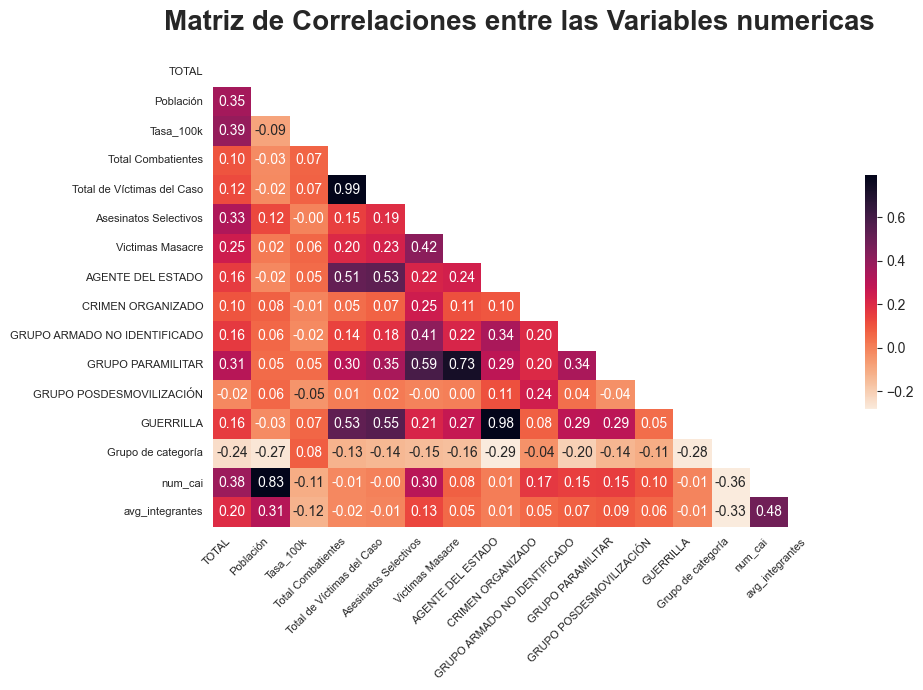

In [49]:

var_numericas = ['TOTAL', 'Población', 'Tasa_100k', 'Total Combatientes',
       'Total de Víctimas del Caso', 'Asesinatos Selectivos',
       'Victimas Masacre', 'AGENTE DEL ESTADO', 'CRIMEN ORGANIZADO',
       'GRUPO ARMADO NO IDENTIFICADO', 'GRUPO PARAMILITAR',
       'GRUPO POSDESMOVILIZACIÓN', 'GUERRILLA','Grupo de categoría', 'num_cai', 'avg_integrantes']

base_numericas = df1[var_numericas]

correlation_matrix = base_numericas.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
with sns.axes_style("white"):
    with sns.plotting_context(font_scale=0.8):
        plt.figure(figsize=(10, 7))
        sns.heatmap(correlation_matrix, mask=mask, cmap='rocket_r' , annot=True, fmt=".2f", robust=True, linecolor='white',
            cbar_kws={"shrink": .5, "ticks": np.linspace(-1, 1, 11)},)
        plt.title('Matriz de Correlaciones entre las Variables numericas', fontsize=20, weight='bold', pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.tight_layout()
        plt.show()

The correlation matrix among numerical variables yields several key insights:

1. **Kidnappings and Population/Institutional Presence**  
   - The total number of kidnappings (“TOTAL”) shows a moderate correlation with population (0.35) and with the number of CAIs (0.38), confirming that absolute counts tend to concentrate in more populated areas with greater police infrastructure.  
   - The kidnapping rate per 100,000 inhabitants (“Tasa_100k”) correlates positively with the total kidnappings (0.39) but weakly with population (−0.09), reinforcing that high rates occur in small municipalities where a few cases greatly inflate the indicator.

2. **Armed Violence and Victims**  
   - Massacre victim counts correlate with selective killings (0.20) and very strongly with paramilitary group presence (0.73), suggesting that where massacres occurred, there were also kidnappings involving multiple victims.  
   - Paramilitary presence has high correlation with massacre victims (0.59) and with state agent actions (0.53), while guerrilla presence is strongly associated with total victims in the event (0.98) and with selective killings (0.53).

3. **Institutional Dependence**  
   - The number of CAIs is very closely tied to population (0.83), indicating that the distribution of police infrastructure follows demographic size almost exclusively, not per-capita violence.  
   - The average group size per municipality (“avg_integrantes”) shows a moderate correlation with total kidnappings (0.20) and with population (0.31), suggesting that larger armed groups operate in more populated areas with more cases.  
   - Additionally, the number of CAIs and police officers correlates strongly negatively (−0.36, −0.33) with the municipality’s security category, indicating that these areas lacked state presence, which we had already concluded.  


 

## QQ-Plots and Statistical Tests for Normality

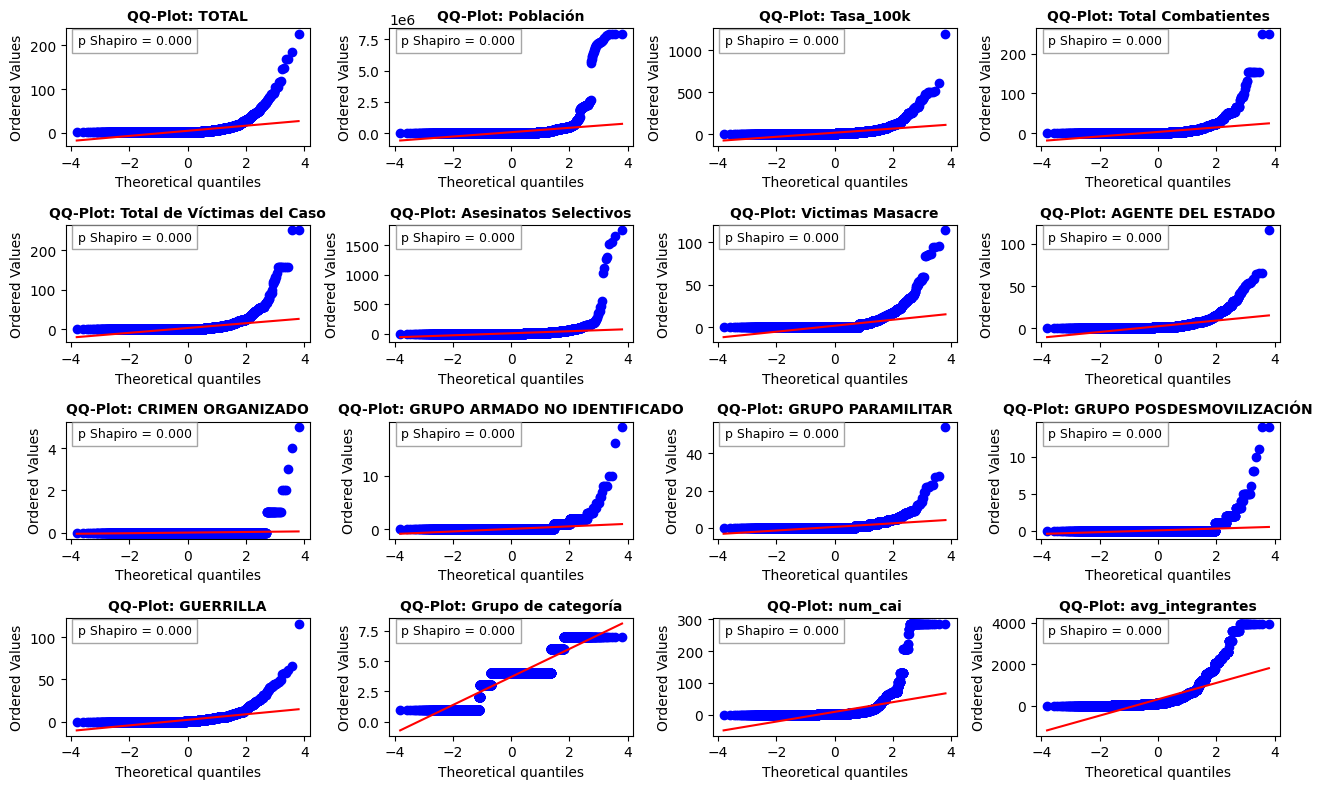

In [46]:

def qqplot(var, name, ax):
    """
    Dibuja un gráfico QQ de `var` frente a una normal en el eje dado,
    añade el p-valor de Shapiro–Wilk como anotación y devuelve el eje.

    Parámetros
    ----------
    var : pandas.Series
        Serie de datos a probar y graficar (se ignoran los valores nulos).
    name : str
        Etiqueta para el título del gráfico.
    ax : matplotlib.axes.Axes o None
        Eje donde dibujar. Si es None, crea una nueva figura y eje.

    Devuelve
    -------
    matplotlib.axes.Axes
        El objeto Axes que contiene el QQ-plot.
    """
    data = var.dropna()
    stat, p_value = stats.shapiro(data)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    stats.probplot(data, dist="norm", plot=ax)
    ax.set_title(f'QQ-Plot: {name}', fontsize=10, weight='bold')

    ax.text(0.05, 0.95,f'p Shapiro = {p_value:.3f}',
        transform=ax.transAxes,verticalalignment='top',fontsize=9,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
    return ax

fig, axes = plt.subplots(4, 4, figsize=(13, 8))
axes_flat = axes.flatten()

for idx, var in enumerate(var_numericas):
    qqplot(df1[var], var, ax=axes_flat[idx])

for ax in axes_flat[len(var_numericas):]:
    ax.axis('off')

fig.tight_layout()
plt.show()

The graph is quite expressive, none of our variables are normal.

## Analysis and Graphics using PCA

In [ ]:
numeric_df = df1.select_dtypes(include=[np.number]).drop(columns=['AÑO'	,'COD_DEPTO'	,'COD_MUNI'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

pca = PCA(n_components=2) ## Dos componentes principales para graficar en un R2
principal_components = pca.fit_transform(scaled_data)

pc_df = pd.DataFrame(data=principal_components,
    columns=['PC1', 'PC2'],
    index=df.index )

loadings = pd.DataFrame(
    pca.components_.T,
    index=numeric_df.columns,
    columns=['PC1','PC2'])

### Now we can understand the composition of the 2 main components

In [60]:
top_PC1 = loadings['PC1'].abs().sort_values(ascending=False).head(5)
print("Variables con mayor carga en PC1:\n", top_PC1)

# 3. Y similar para PC2
top_PC2 = loadings['PC2'].abs().sort_values(ascending=False).head(5)
print("\nVariables con mayor carga en PC2:\n", top_PC2)

Variables con mayor carga en PC1:
 TOTAL                    0.322601
GRUPO PARAMILITAR        0.310414
AGENTE DEL ESTADO        0.289622
GUERRILLA                0.288376
Asesinatos Selectivos    0.281340
Name: PC1, dtype: float64

Variables con mayor carga en PC2:
 num_cai                       0.368579
Población                     0.356958
Total Combatientes            0.352549
Total de Víctimas del Caso    0.351473
GUERRILLA                     0.331754
Name: PC2, dtype: float64


PC1 essentially measures the overall intensity of the conflict and the total number of kidnappings/incidents associated with various armed actors. A high PC1 value in a municipality indicates that there were many kidnappings (“TOTAL”) and, in particular, a strong presence of paramilitaries, state agents, guerrilla forces, and selective killings. A low PC1 value corresponds to areas with very little of that activity.

PC2 reflects population size and security infrastructure along with the specific intensity of combat. Municipalities with high PC2 tend to be more populated, have more CAIs (police stations), and a greater number of combatants and victims (including guerrilla presence). Municipalities with low PC2 are typically small areas with little police presence and fewer confrontations.

One way to name the principal components could be:  
- **PC1**: “Total Violence Level”  
- **PC2**: “Infrastructure and Conflict Magnitude”  


### Graphing the Principal Components

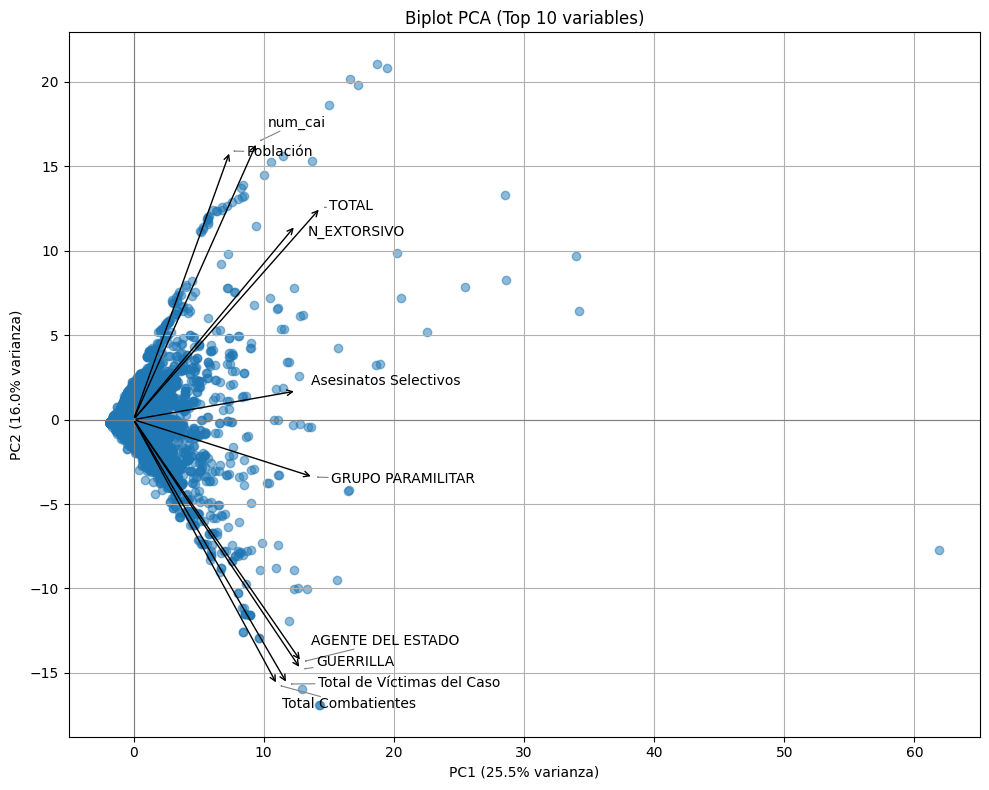

In [64]:
# Seleccionar top 10 variables por carga absoluta máxima
abs_load = loadings.abs()
top_vars = abs_load.max(axis=1).nlargest(10).index

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(pc_df.PC1, pc_df.PC2, alpha=0.5)


ax.axhline(0, color='grey', linewidth=0.8)
ax.axvline(0, color='grey', linewidth=0.8)


texts = []
scale = max(pc_df.PC1.max() - pc_df.PC1.min(),pc_df.PC2.max() - pc_df.PC2.min())
arrow_scale = 0.7

# Ajustar los ejes de los componentes 
for var in top_vars:
    x, y = loadings.loc[var] * arrow_scale * scale
    ax.annotate('', xy=(x, y), xytext=(0, 0),arrowprops=dict(arrowstyle='->', color='black', lw=1))
    texts.append(ax.text(x, y, var, fontsize=10))

adjust_text(texts,  only_move={'points':'y', 'texts':'xy'}, arrowprops=dict(arrowstyle='->', color='gray', lw=0.8))


ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)')
ax.set_title('Biplot PCA (Top 10 variables)')
ax.grid(True)
plt.tight_layout()
plt.show()

The interpretation of this plot can be as follows: Points to the right (high PC1) indicate municipalities with many kidnappings and active armed actors.  
Points above (high PC2) denote larger municipalities or those with more police infrastructure and combatants/victims. Those in the upper-right quadrant combine both traits: large places with intense violence. Finally, a negative PC2 corresponds to municipalities with low population, few CAIs, fewer combatants/victims, and less guerrilla presence than the sample’s average.

We can see that there are more points in the positive PC1 area, moving away from the origin on the X-axis, meaning our sample includes several municipalities with very high violence and a large number of kidnappings.  


***
# 3. Econometric Regressions
***

Since we have a panel data set covering several municipalities, we can apply econometric regressions for panel data to capture variations between and within the data.

First, we must dummify all categorical variables, eliminate unnecessary ones, and check the VIF for correlated variables.

In [119]:
df_dummies = pd.get_dummies(
    df1,
    columns=categorical_features,   
    prefix=['Presencia', 'Intensidad' , 'Categoría'],     
    drop_first=True,             
    dtype=int).drop(columns=['COD_DEPTO' , 'DEPARTAMENTO' , 'COD_MUNI' ]) # Eliminamos las variables no utiles 

df_dummies_regresion = df_dummies.drop(columns=['Total de Víctimas del Caso', 'N_SIMPLE' , 'N_EXTORSIVO']) #Estas variables las eliminamos debido a que en el 
df_dummies_regresion.head()                                                                                # analisis de correlacion tenian correlacion muy alta


,AÑO,MUNICIPIO,TOTAL,Población,Tasa_100k,Total Combatientes,Asesinatos Selectivos,Victimas Masacre,AGENTE DEL ESTADO,CRIMEN ORGANIZADO,...,avg_integrantes,Presencia_Sin conflicto,Presencia_conflicto interrumpido,Presencia_conflicto pacificado,Intensidad_baja intensidad,Categoría_Fuertemente afectados y persistente,Categoría_Levemente afectados e interrumpido,Categoría_Levemente afectados y finalizado,Categoría_Levemente afectados y persistente,Categoría_Sin conflicto
0,1996,MEDELLIN,81,1787831,4.530630,12.0,1036.0,37.0,7.0,0.0,...,1531.538462,0,0,0,0,1,0,0,0,0
1,1996,ABEJORRAL,2,25094,7.970033,5.0,4.0,4.0,5.0,0.0,...,72.000000,0,1,0,1,0,1,0,0,0
2,1996,AMAGA,2,25201,7.936193,0.0,11.0,0.0,0.0,0.0,...,77.000000,0,1,0,1,0,1,0,0,0
3,1996,AMALFI,2,20966,9.539254,0.0,14.0,0.0,0.0,0.0,...,42.000000,0,1,0,1,0,1,0,0,0
4,1996,ANDES,2,41359,4.835707,6.0,30.0,4.0,2.0,0.0,...,181.000000,0,1,0,1,0,1,0,0,0


### Houseman test to choose between fixed or random effects

In [112]:
df_dummies_regresion['AÑO'] =  pd.to_datetime(df_dummies_regresion['AÑO'].astype(str),format='%Y')
df_dummies_regresion = df_dummies_regresion.set_index(['MUNICIPIO', 'AÑO'])

y = df_dummies_regresion['TOTAL']
X = df_dummies_regresion[list(df_dummies_regresion.columns)[3:]]
X = sm.add_constant(X)

# Verificamos que no haya ninguna columna perfectamente correlacionada para estimar correctamente los betas
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])]})

infinite_feats = vif_data.loc[np.isinf(vif_data['VIF']), 'feature'].tolist() 
X = X.drop(columns=infinite_feats) # Eliminamos las columnas con un VIF infinot (correlacion perfecto)

## Estimar efectos Aleatorios 
model_re = RandomEffects(y, X)
re_results = model_re.fit()

## Estimar efectos fijos
fe_mod = PanelOLS(y, X, entity_effects=True) 
fe_res = fe_mod.fit(cov_type='clustered', cluster_entity=True)

# Extimar coeficientes y matrices de covarianza
b_fe = fe_res.params
b_re = re_results.params.reindex(b_fe.index)
V_fe = fe_res.cov.loc[b_fe.index, b_fe.index]
V_re = re_results.cov.loc[b_fe.index, b_fe.index]

# Calcular el Test de Houseman
b_diff = b_fe - b_re
V_diff = V_fe - V_re

stat = float(b_diff.T.dot(np.linalg.inv(V_diff)).dot(b_diff))
df_h = b_diff.shape[0]
p_value = 1 - chi2.cdf(stat, df_h)

print(f"\nHausman χ²({df_h}) = {stat:.2f}, p-value = {p_value:.3f}")

# Interpretar el p valor 
if p_value < 0.05:
    print("p < 0.05 ⇒ Rechazamos H0 ⇒ Efectos Aleatorios NO son consistentes ⇒ Entonces usar EFECTOS FIJOS.")
else:
    print("p ≥ 0.05 ⇒ No rechazamos H0 ⇒ Efectos Aleatorios consistentes ⇒ Entonces usar EFECTOS ALEATORIOS.")

C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Hausman χ²(12) = 884.50, p-value = 0.000
p < 0.05 ⇒ Rechazamos H0 ⇒ Efectos Aleatorios NO son consistentes ⇒ Entonces usar EFECTOS FIJOS.


As we can see, there is enough statistical evidence to not accept the null hypothesis, which is why we conclude that the best regression to run on our data set is a **Fixed Effects Regression**

### Regression with fixed effects

In [114]:
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  TOTAL   R-squared:                        0.1882
Estimator:                   PanelOLS   R-squared (Between):             -19.479
No. Observations:                9837   R-squared (Within):               0.1882
Date:              jue., jul. 03 2025   R-squared (Overall):             -6.5315
Time:                        01:23:59   Log-likelihood                -3.317e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      187.98
Entities:                         909   P-value                           0.0000
Avg Obs:                       10.822   Distribution:                 F(11,8917)
Min Obs:                       1.0000                                           
Max Obs:                       177.00   F-statistic (robust):             102.67
                            

### **Interpretation of the Fixed Effects Model**

After removing all highly correlated columns, we retained the following 11 variables for the regression.

**Estimated Equation**  
$$
\begin{aligned}
\text{TOTAL}_{it} =\;& 9.20 \\
&+\,0.0385\;\times\;\text{Asesinatos Selectivos}_{it} \\
&+\,0.1265\;\times\;\text{Víctimas Masacre}_{it} \\
&+\,0.4969\;\times\;\text{Grupo Paramilitar}_{it} \\
&-\,0.6137\;\times\;\text{Posdesmovilización}_{it} \\
&+\,0.1469\;\times\;\text{Guerrilla}_{it} \\
&-\,0.8235\;\times\;\text{num\_cai}_{it} \\
&+\;\dots
\end{aligned}
$$

The first thing that stands out is the negative overall $R^2$. Although this may seem like an error, it is not: when we estimate a fixed-effects regression, the entity means are removed so that coefficients are fitted only to within-entity variation. This can cause the global explained variance to fall below the baseline, resulting in negative $R^2$. The main focus should be on the “Within” $R^2$ to assess the model’s internal, time-series fit for each municipality.

**Significant Effects (α = 10%)**  
- **Selective Killings**: each additional incident is associated with **+0.0384 kidnappings**.  
- **Massacre Victims**: one more victim contributes **+0.1235 kidnappings**.  
- **Paramilitary Presence**: increases kidnappings by **+0.5055**.  
- **Post-demobilization**: reduces kidnappings by **−0.5685**.  
- **num_cai**: each additional CAI reduces kidnappings by **−0.8236**, confirming its deterrent effect.

**Non-Significant Effects (α = 10%)**  
- Total Combatants, State Agents, Organized Crime, Unidentified Armed Groups, Guerrilla Presence, and avg_integrantes all have p > 0.10 and do not significantly explain kidnappings in this model.

**Regression Conclusion**  
After fitting the fixed-effects regression, the positive associations of selective killings and paramilitary presence with the number of kidnappings persist, as does the clear deterrent effect of greater institutional presence. Post-demobilization exerts a significant negative effect. Some violence indicators (massacres, guerrilla presence) lose statistical significance here, likely due to insufficient within-municipality variability. The robust F-test (p < 0.001) and the Within $R^2$ (≈ 0.188) ensure that, despite the low global explanatory power, the detected coefficients represent consistent relationships **within the same municipalities** over time.  




***
# 4. Machine Learning 
***

As we have seen, the regressions are simple and capture the panel dynamics, but they have poor predictive power. Therefore, we will build a more advanced model using ML boosting methods (eXtreme Gradient Boosting) to better capture nonlinear interactions. Additionally, because ML models are not affected by multicollinearity or highly correlated variables, we will perform feature engineering to provide the model with as much information as possible so it can learn optimally.

Finally, we will use SHAP values to interpret the model’s predictions. This way, we can retain the strength of linear regressions—interpretability—while improving on their Achilles’ heel: the high bias they exhibit when dealing with complex interactions.  



### Feature Engeneering 

In [255]:
df_ml = df_dummies.copy()

df_ml['victimas_pc'] = (df_ml['Total de Víctimas del Caso']  + 
                             df_ml['Asesinatos Selectivos'] + df_ml['Victimas Masacre'] ) / (df_ml['Población']) # Víctimas per cápita

df_ml['violencia_estruct'] = (df_ml['Asesinatos Selectivos'] + df_ml['Victimas Masacre']) / df_ml['TOTAL'] # Tasa de violencia estructural

df_ml['share_guerrilla'] = (df_ml['GUERRILLA'].div(df_ml['Total Combatientes']).replace([np.inf, -np.inf], 0).fillna(0)) # Densidad de Guerrilla 
df_ml['cobertura_cai'] = df_ml['num_cai'] / df_ml['Población']
df_ml['personal_pc'] = df_ml['avg_integrantes'] / df_ml['Población'] # Indices de cantidd de cais y policias por municipio en funcion de la poblacion

df_ml['diff_guerrilla_param'] = (df_ml['GUERRILLA'] - df_ml['GRUPO PARAMILITAR']) / (df_ml['GUERRILLA'] + df_ml['GRUPO PARAMILITAR'] + 1) #capturar desequilibrios de poder local.

## Incluir una dinamica temporal. Esto es uan gran ventaja de los modelos de ML podemos tratar de recrear un VAR con los mismos modelos 

df_ml['TOTAL_lag1'] = (df_ml.groupby('MUNICIPIO')['TOTAL'].shift(1)).fillna(0) # Un rezago de la serie 

df_ml['TOTAL_roll3'] = (df_ml.groupby('MUNICIPIO')['TOTAL']
    .rolling(window=3, min_periods=1).mean()
    .reset_index(level=0, drop=True)) # Media movil a 3 a;os para no tener en cuenta choques transitorios

df_ml.shape

(9837, 37)

In [263]:
df_ml.to_csv('Base_para_ML.csv', index=False, encoding='utf-8')

After creating these new features, we obtain 37 features that can be used to predict the number of kidnappings. The remaining features are the dependent variable y, the municipality (because it would generate many dummies), and the number of simple and extortionate kidnappings, since it doesn't make sense to predict kidnappings with the same types of kidnappings.

### Data preprocessing

In [256]:

X = df_ml.drop(columns=['MUNICIPIO', 'N_SIMPLE', 'N_EXTORSIVO', 'TOTAL' ,'Categoría_Sin conflicto'])
y = df_ml['TOTAL']

# Dividir entre Trian-Test 80% 20%
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
dummy_cols = [col for col in numeric_features if set(X[col].unique()).issubset({0, 1})]
real_numeric = [col for col in numeric_features  if col not in dummy_cols] ## De este modo no escalamos las variables dumyy

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]),real_numeric # los datos numericos seran escalados con StandarScaler 
        )],remainder="passthrough") # los datos categoricos ya fueron dummyficados asi que no toca hacer ningun preprocecamienti 

X_train_final = preprocessor.fit_transform(X_train_raw)
X_test_final  = preprocessor.transform(X_test_raw)


In [257]:
print(X_train_final.shape , y_train.shape)
print(X_test_final.shape , y_test.shape)

(7869, 32) (7869,)
(1968, 32) (1968,)


We were left with 34 variables because we chose the 25 numeric + 9 categorical dummy variables that we already had.

## **XGBoost**

We will use XGBoost for its ease of implementation and its great reputation for capturing complex skills, in turn we will implement a manual hyperparameter search that maximizes the r2 in train and test (to avoid overfitting models), in this way we manage to find the best possible XGBoost for our data

In [258]:
# Creamos un diccionario de Hiperparamtetros a optimizar 
best = {
    'R2_validacion': -np.inf,
    'R2_testeo': -np.inf,
    'n_estimators': None,
    'max_depth': None,
    'learning_rate': None,
    'subsample': None,
    'colsample_bytree': None,
    'gamma': None,
    'min_child_weight': None,
    'reg_alpha': None,
    'reg_lambda': None}

# Creamos un diccionario para guardar el mejor modelo
modelo = {'model' : None}

# Creamos un modelo de posibles configuraciones de Hiperparametros 
param_grid = {
    'n_estimators': list(range(50, 300, 50)),
    'max_depth': list(range(2, 16)),
    'learning_rate': list(np.linspace(0.01, 0.3, 30)),
    'subsample': list(np.linspace(0.6, 1.0, 20)),
    'colsample_bytree': list(np.linspace(0.6, 1.0, 20)),
    'gamma': list(np.linspace(0, 0.5, 20)),
    'min_child_weight': [1, 3, 5, 7, 10],
    'reg_alpha': [0, 0.1, 1, 5, 10],
    'reg_lambda': [0.1, 1, 5, 10]}

# Corremos 10 modelos en donde: 
for i in range(10):
    
    # Seleccioanmos automaticamente una configuracion de hiperparametros 
    params = {k: random.choice(v) for k, v in param_grid.items()}

    # Creamos el modelo 
    model = XGBRegressor(objective='reg:squarederror',**params)

    model.fit(X_train_final , y_train) # Entrenamos el modelo 
       
    r2_val = cross_val_score(model , X_train_final , y_train , cv=5, scoring='r2').mean() # Calculamos el r2 de validacion  

    y_test_pred = model.predict(X_test_final) # Hacemos las predicciones 
    r2_test = r2_score(y_test, y_test_pred) # calculamos el R2 de prediccion 

    if (r2_val > best['R2_validacion'] and r2_test > best['R2_testeo']): # Actualizamos el modelo si fue mejor que el ultimo mejor 
        best.update({ 
            'R2_validacion':r2_val,
            'R2_testeo':r2_test,
            **params})
        
        modelo['model'] = model
        print(f"Iter {i}: nuevo mejor → {best}")
    
    # Creamos un criterio de parada 
    if best['R2_validacion'] >= 0.90 and best['R2_testeo'] >= 0.93:
        print("Objetivo alcanzado, detenemos el search")
        break



Iter 0: nuevo mejor → {'R2_validacion': 0.8421516733374949, 'R2_testeo': 0.8680512090599648, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.25999999999999995, 'subsample': 0.9578947368421052, 'colsample_bytree': 0.7684210526315789, 'gamma': 0.05263157894736842, 'min_child_weight': 3, 'reg_alpha': 10, 'reg_lambda': 10}
Iter 1: nuevo mejor → {'R2_validacion': 0.9120163395598515, 'R2_testeo': 0.9200817230169123, 'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.10999999999999997, 'subsample': 0.8526315789473684, 'colsample_bytree': 0.9157894736842105, 'gamma': 0.4473684210526315, 'min_child_weight': 7, 'reg_alpha': 5, 'reg_lambda': 10}


The best Xgboost has 150 associated decision trees, each with a maximum depth of 11, the other hyperpairs are more technical and control the gradient descent and regularization of XGBoost itself.

### We validate the model with additional metrics

In [260]:
y_pred = modelo['model'].predict(X_test_final) # Selccionamos el mejor modelo 

# 2. Calcular métricas
r2   = r2_score(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)

# 3. Mostrar resultados
print(f"R² en test: {r2:.4f}")
print(f"MSE en test: {mse:.4f}")
print(f"MAE en test:{mae:.4f}")

R² en test: 0.9201
MSE en test: 7.3353
MAE en test:0.5332


- **R²**: While the fixed-effects model explained only 18.8% of the within-municipality variation, XGBoost achieves an R² of 92.2% on test data, indicating a much stronger predictive fit.  
- **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)**: These metrics are only available for XGBoost, with MSE = 7.3 and MAE = 0.53, indicating very low prediction errors on the scale of monthly kidnappings.

Overall, XGBoost dramatically improves predictive capability on the same data, thanks to its nonlinear flexibility in handling interactions and its ability to include highly correlated and pure time-series variables without issue.

A challenge with these ML models is that they are very difficult to interpret; their parameters are not directly economically explainable like regression betas. However, we can address this using techniques such as SHAP values.  


## Shap Values

SHAP values (SHapley Additive exPlanations) are a model interpretation technique based on game theory. For each prediction, they calculate how much each feature contributes to the outcome by comparing the change in prediction with and without that feature, averaged over all possible background feature combinations. Mathematically, each variable is assigned a Shapley value,

$$
\phi_i = \sum_{S\subseteq F\setminus\{i\}} \frac{|S|!\,(|F|-|S|-1)!}{|F|!}\bigl[f(S\cup\{i\}) - f(S)\bigr],
$$

where $F$ is the set of all features, $S$ is a subset not containing $i$, and $f(\cdot)$ is the model’s prediction. The result is an additive decomposition of the final prediction into individual contributions from each variable, facilitating interpretation and comparison across instances.  



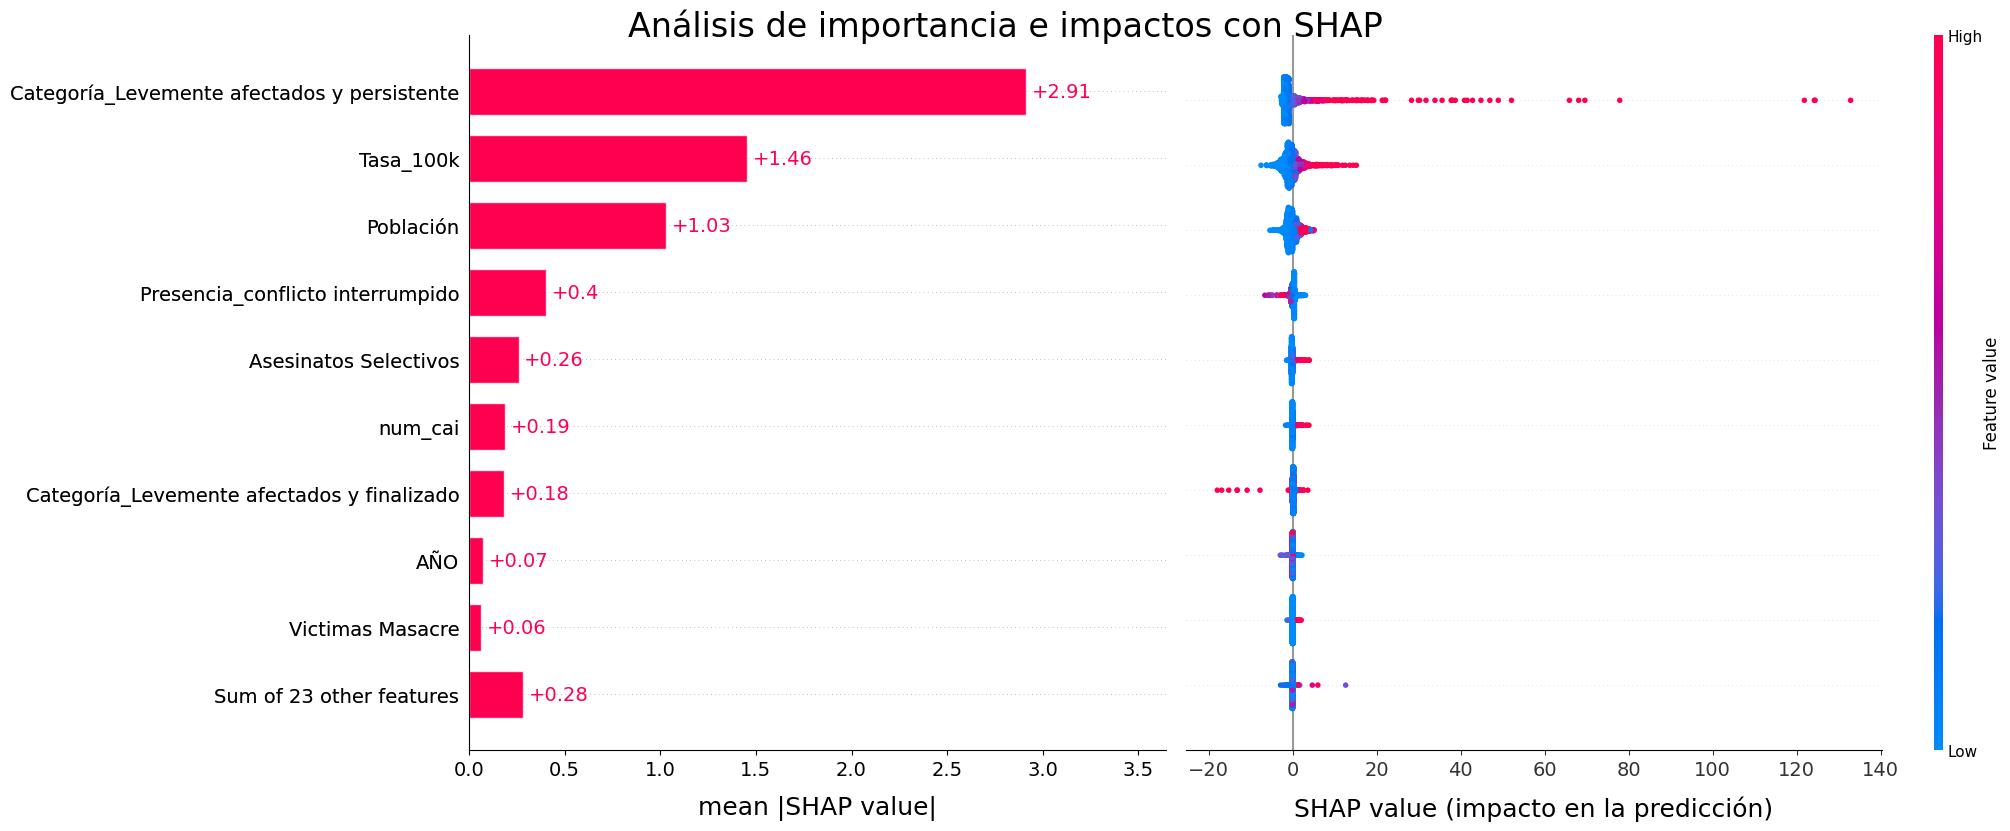

In [259]:

# Calculamos los Valores Shap
feature_names = numeric_features + categorical_features
x_test_df  = pd.DataFrame(X_test_final,  columns=feature_names)
explainer = shap.TreeExplainer(modelo['model']) 
shap_values = explainer.shap_values(x_test_df) 

explainer = explainer        
shap_exp   = explainer(x_test_df) 


# Creamos las graficas para analizar 
fig, axes = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)
fig.suptitle("Análisis de importancia e impactos con SHAP", fontsize=24, y=1.02)


order = np.abs(shap_exp.values).mean(0).argsort()[::-1]
shap.plots.bar(shap_exp,
    order=order,show=False,ax=axes[0])
axes[0].set_xlabel("mean |SHAP value|", fontsize=18, labelpad=12)
axes[0].tick_params(labelsize=14)

xmax = np.abs(shap_exp.values).mean(0).max() * 1.25
axes[0].set_xlim(0, xmax)
for txt in axes[0].texts:
    txt.set_fontsize(14)

shap.plots.beeswarm(
    shap_exp,
    show=False,
    plot_size=None,
    ax=axes[1])

axes[1].tick_params(axis="y", left=False, labelleft=False)
if axes[1].collections and getattr(axes[1].collections[-1], "colorbar", None):
    axes[1].collections[-1].colorbar.remove()

axes[1].set_xlabel("SHAP value (impacto en la predicción)", fontsize=18, labelpad=12)
axes[1].tick_params(labelsize=14)

plt.show()

### SHAP Values (XGBoost)

1. **Bar Chart (mean |SHAP|)**  
   - **Categoría_Levemente afectados y persistente** is the most influential variable (mean |SHAP| ≈ 2.91). This means that belonging to a municipality with a “slightly affected & persistent” conflict status drives the kidnapping prediction more than any other factor. One of the main reasons for this is that, as we saw, the peak violence period lasted only 12 years in our series and the model must learn across the entire timeframe. This translates into the model learning the current era well, and this top variable reflects that in the current period (2009 onward), belonging to a “slightly affected” municipality pushes kidnappings upward. To predict more turbulent violence periods, the model learned from other variables—such as that the conflict was “interrupted” (since many high-violence areas are now at peace).

   - **Tasa_100k** ranks second (≈ 1.46), reinforcing that the relative incidence remains a major determinant, though secondary to this conflict category.  
   - **Population** comes in third (≈ 1.03), confirming that municipality size also plays an important, though lesser, role than conflict persistence.  
   - It is followed by **Presencia_conflicto interrumpido** (≈ 0.40), **Selective Killings** (≈ 0.26), and **num_cai** (≈ 0.19). The remaining variables (years, massacres, other conflict categories) have lower mean impacts.

2. **Beeswarm (Impact Distribution)**  
   - Each point represents a municipality-month; its color (blue to red) indicates the feature value and its horizontal position the impact on the prediction.  
   - For **Categoría_Levemente afectados y persistente**, red points (municipalities with this condition) appear far to the right, with impacts up to +120 kidnappings. Blue points (not in this category) cluster around zero.  
   - In **Tasa_100k**, red points continue to push the prediction up (up to +30–+40), while blue points dampen it.  
   - In **Population**, larger municipalities (red) moderately increase predictions (up to +15–+20), and smaller ones (blue) decrease them.  
   - For **num_cai**, red points cluster left of zero, reaffirming the mitigating effect of more police posts.

The SHAP ranking reveals that being “slightly affected & persistent” is currently the top variable for predicting kidnappings. The normalized rate per 100k inhabitants and population remain relevant, while institutional presence (`num_cai`) consistently acts as a mitigating factor. This order corrects our previous view and highlights the centrality of conflict persistence in current kidnapping dynamics.

Additionally, we can conclude that for straightforward, easily interpretable conclusions, a regression is the simplest approach, but for forecasting the series, this model vastly outperforms econometric regressions.  





***
# 5. Deep Learning 
***

With this block we want to compare whether a neural network can have a performance similar to that achieved by XGBoost

### We run the same preprocessing again but now we will use train - validation - test to train the network optimally

In [3]:
df_ml = pd.read_csv('../Datos/Base_para_ML.csv')

X = df_ml.drop(columns=['MUNICIPIO', 'N_SIMPLE', 'N_EXTORSIVO', 'TOTAL' ])
y = df_ml['TOTAL']

# Dividir entre Trian-val 60% 20% 10%
X_temp, X_test_raw, y_temp, y_test = train_test_split(
    X, y,test_size=0.10,random_state=42)

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_temp, y_temp,test_size=0.2222,random_state=42)


numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
dummy_cols = [col for col in numeric_features if set(X[col].unique()).issubset({0, 1})]
real_numeric = [col for col in numeric_features if col not in dummy_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), real_numeric)],
    remainder="passthrough" )

X_train_final = preprocessor.fit_transform(X_train_raw)
X_val_final   = preprocessor.transform(X_val_raw)
X_test_final  = preprocessor.transform(X_test_raw)

print("Train set:",  X_train_final.shape, y_train.shape)
print("Validation set:", X_val_final.shape,   y_val.shape)
print("Test set:", X_test_final.shape,  y_test.shape)

Train set: (6885, 33) (6885,)
Validation set: (1968, 33) (1968,)
Test set: (984, 33) (984,)


### Converting numpy arrays to torch tensors

In [4]:
X_train_tensor = torch.from_numpy(X_train_final).float() 
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) 

X_val_tensor = torch.from_numpy(X_val_final).float() 
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.long) 

X_test_tensor  = torch.from_numpy(X_test_final).float() 
y_test_tensor  = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [5]:
print(X_train_tensor.shape , y_train_tensor.shape)
print(X_val_tensor.shape , y_val_tensor.shape)
print(X_test_tensor.shape , y_test_tensor.shape)

torch.Size([6885, 33]) torch.Size([6885])
torch.Size([1968, 33]) torch.Size([1968])
torch.Size([984, 33]) torch.Size([984])


We can see that the dimensions are congruent in all sets

### Now we create the TensorDatasets objects to later create the DataLoaders

In [6]:
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds  = TensorDataset(X_test_tensor,  y_test_tensor)

### Since we have everything we need from the data, we can begin creating the functions required to train a network with hyperparameter optimization. These functions are:
- A function that creates a network
- A function that trains the network for one epoch
- A function to evaluate the trained network

In [7]:
def crear_red(dim_entrada , neuronas_capas):
    """
    Genera una instancia de una red neuronal densa con arquitectura y
    regularizaciones seleccionadas aleatoriamente.

    La red se construye con:
      - Capas lineales definidas por `dim_entrada`, `neuronas_capas` y salida de tamaño 1 (problema de regresion).
      - Opciones aleatorias de función de activación (ReLU, Tanh , LeakyRelu).
      - Opciones aleatorias de aplicar Batch Normalization tras la capa lineal.
      - Opciones aleatorias de aplicar Dropout tras la capa (prob. de 0.1 a 0.5).

    Parámetros
    ----------
    dim_entrada : int
        Número de características de entrada.
    neuronas_capas : list[int]
        Lista con el número de neuronas en cada capa oculta, en orden.

    Retorna
    -------
    model : nn.Module
        Instancia de `RedNeuronal`, con la arquitectura y regularizaciones
        definidas según las elecciones aleatorias realizadas.
    """

    # Crear un numero de opciones para optimizar 
    funciones_activacion = [nn.ReLU() , nn.Tanh() ,nn.LeakyReLU(negative_slope=0.01)]
    batch_opciones = [ True, False ]
    opcion_regularizacion =[0.10 , 0.20 , 0.30 , 0.40 , 0.50]

    class RedNeuronal(nn.Module):
        def __init__(self, dim_entrada, neuronas_capas:list, dim_salida = 1):
            super().__init__()

            dimension_total = [dim_entrada] + neuronas_capas + [dim_salida]
            capas: list[nn.Module] = []


            for i in range(len(dimension_total)-2):
                # Seleccionar aleatoriamente una de las opciones 
                opcion_activacion = random.choice(funciones_activacion)
                opcion_batch = random.choice(batch_opciones)
                opcion_drop = random.choice(batch_opciones)
                opcion_regu = random.choice(opcion_regularizacion)

                capas.append(nn.Linear(dimension_total[i], dimension_total[i+1]))

                # Agregamos Batch Normalization si aleatoriamente sucede 
                if opcion_batch: 
                    capas.append(nn.BatchNorm1d(dimension_total[i+1]))
         
                if opcion_drop:
                    capas.append(nn.Dropout(p=opcion_regu))

                capas.append(opcion_activacion)
            
            capas.append(nn.Linear(dimension_total[-2], dimension_total[-1]))  

            self.net = nn.Sequential(*capas)
        
        def forward(self , x):
            return self.net(x)
    
    return RedNeuronal(dim_entrada , neuronas_capas)


def train_epoch(dataloader, model, optimizer, criterion):
    """
    Entrena el modelo una época usando el DataLoader, el optimizador y la función de pérdida dada,
    y calcula el R².

    Args:
        dataloader (DataLoader): Iterable de tu dataset de entrenamiento, devuelve (inputs, targets).
        model (nn.Module): Modelo de PyTorch a entrenar.
        optimizer (torch.optim.Optimizer): Optimizador para actualizar los parámetros del modelo.
        criterion (callable): Función de pérdida.

    Returns:
        tuple:
            - epoch_r2   (float): Coeficiente de determinación R² sobre la época.
            - epoch_loss (float): Pérdida media por muestra sobre la época.
    """
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for xb, yb in dataloader:
        optimizer.zero_grad()

        outputs = model(xb)  # suponemos salida de tamaño [batch_size, 1]
        loss = criterion(outputs, yb.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        batch_size = xb.size(0)
        running_loss += loss.item() * batch_size

        # Recoger predicciones continuas y valores reales
        preds = outputs.squeeze().detach().cpu().numpy()
        labels = yb.detach().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    # Pérdida media de la época
    epoch_loss = running_loss / len(dataloader.dataset)

    epoch_r2 = r2_score(all_labels, all_preds)

    print(f'Training R2: {epoch_r2:.4f}, Training loss: {epoch_loss:.4f}')
    return epoch_r2, epoch_loss


def evaluate_regression(dataloader, model, criterion, return_preds=False):
    """
    Evalúa el modelo en el conjunto dado usando el DataLoader y la función de pérdida,
    calculando el coeficiente de determinación R².

    Args:
        dataloader (DataLoader): Iterable sobre el dataset de evaluación que rinde batches.
        model (nn.Module): Modelo de PyTorch a evaluar.
        criterion (callable): Función de pérdida para calcular el loss.
        return_preds (bool, optional): Si es True, devuelve además predicciones y etiquetas. Defaults to False.

    Returns:
        tuple:
            - epoch_r2 (float): R² sobre el conjunto de evaluación.
            - epoch_loss (float): Loss promedio por muestra.
            - all_preds (list[float], optional): Predicciones (si return_preds=True).
            - all_labels (list[float], optional): Etiquetas reales (si return_preds=True).
    """
    
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for xb, yb in dataloader:
            outputs = model(xb)  # salida de tamaño [batch_size, 1]
            loss = criterion(outputs, yb.unsqueeze(1).float())

            batch_size = xb.size(0)
            running_loss += loss.item() * batch_size
            total_samples += batch_size

            preds = outputs.squeeze().cpu().numpy()
            labels = yb.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    epoch_loss = running_loss / total_samples
    epoch_r2  = r2_score(all_labels, all_preds)

    if not return_preds:
        print(f'Validation R2: {epoch_r2:.4f}, Validation loss: {epoch_loss:.4f}')
        return epoch_r2, epoch_loss
    else:
        return epoch_r2, epoch_loss, all_preds, all_labels
    



### Now that we have the functions to create and train a network... we can build the function that brings everything together for *n* neural networks with different configurations and selects the best one  


In [18]:
def nn_con_optimizacion(criterion , cantidad_modelos , patience_early_stop , target_r2_train , target_r2_val):
    """
    Realiza una búsqueda aleatoria de arquitecturas y hiperparámetros de redes neuronales,
    entrena cada modelo con early stopping basado en el loss de entrenamiento,
    y selecciona el mejor modelo según R² en entrenamiento y validación.

    Args:
        criterion (callable): Función de pérdida para regresión (p.ej. nn.MSELoss()).
        cantidad_modelos (int): Número máximo de modelos a probar.
        patience_early_stop (int): Ventana de épocas para evaluar estancamiento en el loss.
        target_r2_train (float): Umbral de R² en entrenamiento para detener la búsqueda.
        target_r2_val (float): Umbral de R² en validación para detener la búsqueda.

    Returns:
        best_hiperparametros (dict): Datos del mejor modelo encontrado, con keys:
            - 'Epocas', 'Arquitectura', 'lr', 'batch_size', 'R2_train', 'R2_val'.
        data_loaders (dict): DataLoader de test asociado al mejor modelo.
        best_model (dict): 
            - 'Model': instancia del modelo mejor,
            - 'cahce': lista de training losses por época.
    """

    best_hiperparametros = {'Epocas' : None, 'Arquitectura' : None , 'lr':None , 
                            'batch_size':None , 'R2_train' : 0 , 'R2_val' : 0 , }
    data_loaders = {'test':None}
    best_model = {'Model':None , 'cahce':None}

    #### Hiperparametros Externos ######
    modelos_a_entrenar = cantidad_modelos
    num_ticks = 5 # Cantidad de opciones para el Batch size 
    patience = patience_early_stop
    tol      = 1e-3
    
    #### Hiperparamertor internos #####

    # Opciones Batch Size 
    batch_size = list(range(len(X_train_final)//(num_ticks+1), len(X_train_final), len(X_train_final)//(num_ticks+1))) 
    # Opciones de epocas para cada modelo 
    epocas_por_modelo = list(range(50,200,20))

    # Opciones de arquiteturas por modelo 
    capas_neuronas = [[random.randint(10, 300) for _ in range(random.randint(2, 4))] for _ in range(20)]

    # Opciones para el Learning Rate de Adam 
    lr_options = list(10 ** np.linspace(-6, -2, num=10)) 

    for i in range(modelos_a_entrenar):
        # Seleccionar random un numero de epocas por modelo
        epocas = random.choice(epocas_por_modelo)

        # Seleccionar random el batch size 
        batch_size_opt = random.choice(batch_size)

        # Seleccionar random la arquitectura de la red 
        arq_red = random.choice(capas_neuronas)

        # Seleccionar Random el learning rate 
        lr_rate = random.choice(lr_options)

        # Creamos los DataLoaders antes de entrenar cada modelo para optimizar el Batch_Size
        train_loader = DataLoader(train_ds, batch_size=batch_size_opt, shuffle=True)
        val_loader   = DataLoader(val_ds, batch_size=batch_size_opt) 
        test_loader  = DataLoader(test_ds,batch_size=batch_size_opt)

        model = crear_red(X_train_tensor.size(1), arq_red) 
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        train_loss_cache = []
        clear_output(wait=True)
        
        # ENTRENAR LA RED ALEATORIA #
        for epoch in range(1, epocas):
            
            # Entrenar el modelo 
            entrenamiento_r2 , entrenamiento_loss = train_epoch(train_loader , model , optimizer , criterion)
            # Validar el modelo 
            validacion_r2 , validacion_loss = evaluate_regression(val_loader , model , criterion)
            train_loss_cache.append(entrenamiento_loss) # Guardar en cache el loss 

            # Establecemos un early stopp que monitoree el loss de entrenamiento para evitar overfitting # 
            if len(train_loss_cache) >= patience:
                 window = train_loss_cache[-patience:]
                 # si el rango de perdidas en la ventana es muy pequeño, paramos
                 if max(window) - min(window) < tol:
                    print(f"Early stopping: cambio de loss < {tol} en las últimas {patience} épocas.")
                    break
                 
            if epoch % 10 == 0:
                print(f"[Modelo {i+1}/{modelos_a_entrenar}] Época {epoch:>3}/{epocas:<3}  |  "
                      f"R2_train: {entrenamiento_r2:.4f}  |  R2_val: {validacion_r2:.4f}  |  "
                      f"Loss: {entrenamiento_loss:.2e}")
                 
        # Gradar los datos del modelo si este es mejor que el anterior mejor 
        if entrenamiento_r2 > best_hiperparametros['R2_train'] and validacion_r2 > best_hiperparametros['R2_val']:
            best_hiperparametros['Epocas'] = epocas
            best_hiperparametros['Arquitectura'] = arq_red 
            best_hiperparametros['lr'] = lr_rate 
            best_hiperparametros['batch_size'] = batch_size_opt 
            best_hiperparametros['R2_train'] = entrenamiento_r2 
            best_hiperparametros['R2_val'] = validacion_r2

            best_model['Model'] = model
            best_model['cahce'] = train_loss_cache

            data_loaders['test'] = test_loader
        
        # Establecemops un criterio de parada # 
        if best_hiperparametros['R2_train'] > target_r2_train and best_hiperparametros['R2_val'] > target_r2_val:
            break

    # Una vez terminemos todos los modelos entrenados, o cumplimos el critertio de parada, imprimimos el mejor modelo
    clear_output(wait=True)
    print("""
            --- Mejor hasta ahora ---
            Modelo   : {modelo}
            Épocas   : {epocas}
            Arquitect: {arq}
            Batch    : {bs}
            LR       : {lr:.2e}
            R2_train : {r2t:.4f}
            R2_val   : {r2v:.4f}
                ------------------------
                        """.format(
                                    modelo=i+1,
                                    epocas=best_hiperparametros['Epocas'],
                                    arq=best_hiperparametros['Arquitectura'],
                                    bs=best_hiperparametros['batch_size'],
                                    lr=best_hiperparametros['lr'],
                                    r2t=best_hiperparametros['R2_train'],
                                    r2v=best_hiperparametros['R2_val']))

    return best_hiperparametros , data_loaders , best_model



### Now that we have the architecture created, we can find the best network  


In [19]:
criterion = nn.L1Loss()

hiperparametros, datos, modelo, = nn_con_optimizacion(criterion , cantidad_modelos= 10 , patience_early_stop= 10 , target_r2_train = 0.88 , target_r2_val=0.89 )


                --- Mejor hasta ahora ---
                Modelo   : 10
                Épocas   : 170
                Arquitect: [229, 72, 252]
                Batch    : 5735
                LR       : 1.67e-04
                R2_train : 0.9418
                R2_val   : 0.8169
                ------------------------
                                        


### With the trained network, we can visualize the architecture and the training loss of the selected model:


In [20]:
modelo['Model']

RedNeuronal(
  (net): Sequential(
    (0): Linear(in_features=33, out_features=229, bias=True)
    (1): BatchNorm1d(229, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=229, out_features=72, bias=True)
    (4): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.4, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=72, out_features=252, bias=True)
    (8): BatchNorm1d(252, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): ReLU()
    (11): Linear(in_features=252, out_features=1, bias=True)
  )
)

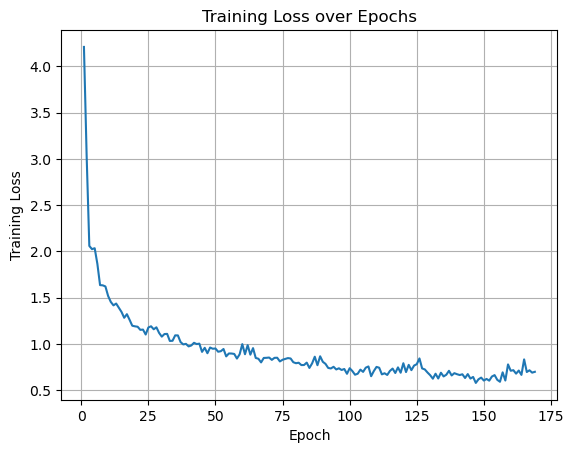

In [25]:
loss_cache = modelo['cahce']
epochs = list(range(1, len(loss_cache) + 1))

plt.figure()
plt.plot(epochs, loss_cache)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

### Calculate the metrics on the test set  


In [26]:
test_r2, test_loss , predicciones , reales = evaluate_regression(datos['test'], modelo['Model'] , criterion , return_preds = True)

print(f'R2 en el test dataset -> {test_r2}')
print(f'Loss del test dataset -> {test_loss}')

R2 en el test dataset -> 0.8958311205550848
Loss del test dataset -> 1.0443780422210693


These metrics tell us that neural networks also perform excellently at predicting kidnappings in the country (R² = 0.89). Depending on the hardware architecture, one might prefer between ML and DL models; the network we found has 3 hidden layers with 299, 72, and 252 neurons each. This is a large network in terms of neurons but not in terms of layers. On the other hand, the optimal XGBoost model used 150 trees. One could analyze which is more computationally expensive, but with a powerful GPU both models run very quickly.

Additionally, XGBoost is at its limit—meaning it’s unlikely you’ll get a better model simply by tweaking its architecture; that would require better data. In contrast, neural networks are universal approximators, which means our hyperparameter grid may not have been optimal or could have benefited more from a Bayesian search instead of a random search. In other words, there is still room for improvement with the neural network, which is already very close in performance to XGBoost.  


***
# 6. **Final Conclusions of the work**
***


### 6.1 Summary of Findings  
- **Historical dynamics and geography of kidnapping**: Monthly kidnapping incidence spiked in the late ’90s and early 2000s, driven by the FARC and paramilitary blocs, then declined and stabilized at low levels after 2010. Maps clearly showed where kidnappings were concentrated (Antioquia, Valle, Santander, Meta, parts of the Plains and Caribbean), and when normalized by population, critical hotspots appeared in low-density municipalities (Vaupés, Guaviare, Caquetá) where “miracle fishings” inflated per-capita rates. Overlaying these maps with guerrilla-violence zones revealed a strong correlation.

  Conversely, we found that police presence and institutional power mitigated kidnapping counts, but in the hardest-hit areas institutional coverage was minimal, giving guerrillas free rein to act as the de facto authority in those municipalities.

- **Panel regressions**: With fixed effects, we identified positive, significant impacts of selective killings (+0.038 kidnappings per incident), massacre victims (+0.12), paramilitary presence (+0.50), and guerrilla presence (+0.15), and reducing effects from post-demobilization (−0.61 kidnappings) and each additional CAI (−0.82). The Within R² (~0.19) reflects a modest but robust fit for capturing local time-series fluctuations.

- **XGBoost SHAP**: The “Slightly affected & persistent” category was the most influential feature (mean |SHAP| ≈ 2.9), followed by the rate per 100,000 inhabitants (≈1.5) and population (≈1.0). Violence proxies (selective killings, interrupted conflicts) and CAI count corroborated linear findings and highlighted their explanatory power in nonlinear scenarios.

- **Neural networks**: As shown by our hyperparameter tuning exercise, neural nets approached the performance of the best XGBoost model, indicating that further refinement of this approach could yield even better results.

### 6.2 Critical Reflections  
- **Impact of historical violence**: Kidnapping levels are intrinsically tied to Colombia’s cycles of political and paramilitary violence. During the peak conflict period (1998–2004), the risk of kidnapping was dramatically higher than today, implying that temporal dynamics continue to condition danger across regions.

- **Reduction of current risk**: Although vulnerabilities persist, the sustained decline suggests that kidnapping is now less likely than in past decades, reflecting security policies, peace agreements, and international pressure. A recent uptick not seen since 2006 highlights state-capacity gaps and rising violence. This study serves as a reminder of how dire Colombia’s situation was when drug-fueled violence reigned.

- **Advantage of ML models**: Machine learning approaches (XGBoost and neural networks) vastly outperform linear regression in predictive power (R² 0.88–0.92 vs. 0.19), but their “black-box” nature complicates causal interpretation—posing the challenge of balancing accuracy and explainability for policy decisions.

- **Demobilization and territorial control policies**: The coefficients for post-demobilization and CAIs reveal that formal peace processes and police deployments had real effects on reducing kidnappings but were unevenly distributed, prompting reflection on how to design interventions that prioritize high per-capita risk areas.

### 6.3 Potential Future Research Directions  
1. **Integration of detailed socioeconomic variables** (income, employment, education) and mobility data to model structural and conjunctural determinants of kidnapping.  
2. **Sequential and spatial models**: Implement recurrent neural networks (LSTM/GRU) or dynamic graphs (GNN) to leverage temporal dimensions and territorial connections among municipalities.  
3. **Advanced hyperparameter optimization** for deep networks (Bayesian optimization) and experiments with hybrid architectures (XGBoost + network embeddings) to capture complex interactions.  
4. **Early-warning systems and dashboards**: Build near-real-time platforms that combine kidnapping series, violence indicators, and social signals (networks, complaints) to guide preventive responses.  


# Data

CERAC - Tipología de los municipios de Colombia según el conflicto armado interno. (s. f.). Google Docs. https://docs.google.com/spreadsheets/d/1ITvbEU79Ok_GhaDmN12mCeHBFfBzoa4GfNT68wyAnXo/edit?gid=1514359174#gid=1514359174

De Estadística, D. A. N. (s. f.). DANE - Proyecciones de población. https://www.dane.gov.co/index.php/estadisticas-por-tema/demografia-y-poblacion/proyecciones-de-poblacion

Directorio de cuadrantes de Metropolitanas y Departamentos de Policía | Datos Abiertos Colombia. (2020, 26 junio). https://www.datos.gov.co/Funci-n-p-blica/Directorio-de-cuadrantes-de-Metropolitanas-y-Depar/jwvi-unqh/about_data

Frentes de Seguridad Policía Nacional | Datos Abiertos Colombia. (2020, 16 septiembre). https://www.datos.gov.co/Gastos-Gubernamentales/Frentes-de-Seguridad-Polic-a-Nacional/cmxv-8tb9/about_data

Mahtani, N., Mahtani, N., & Mahtani, N. (2022, 14 enero). El hambre que conoce la mitad de los colombianos. El País. https://elpais.com/planeta-futuro/2022-01-14/el-hambre-que-conoce-la-mitad-de-los-colombianos.html

Shapes por municipios. (2016, 26 noviembre). https://bogota-laburbano.opendatasoft.com/explore/dataset/shapes/export/?location=7,5.4171,-73.67981&basemap=jawg.streets

Sistema de Información de Eventos de Violencia del Conflicto Armado SIEVCAC - Casos AB Acciones Bélicas | Datos Abiertos Colombia. (2021, 15 octubre). https://www.datos.gov.co/Inclusi-n-Social-y-Reconciliaci-n/Sistema-de-Informaci-n-de-Eventos-de-Violencia-del/39qq-a72j

Sistema de Información de Eventos de Violencia del Conflicto Armado SIEVCAC - Casos MA Masacres | Datos abiertos Colombia. (2021, 30 noviembre). https://www.datos.gov.co/Inclusi-n-Social-y-Reconciliaci-n/Sistema-de-Informaci-n-de-Eventos-de-Violencia-del/d78j-f66e/about_data

Sistema de Información de Eventos de Violencia del Conflicto Armado SIEVCAC - Víctimas AS Asesinatos selectivos | Datos Abiertos Colombia. (2021, 19 octubre). https://www.datos.gov.co/Inclusi-n-Social-y-Reconciliaci-n/Sistema-de-Informaci-n-de-Eventos-de-Violencia-del/djr9-7s3i/about_data

## **Pablo Reyes** 